In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Brain = torch.load( "./actormodel.pth" )

weight_names = []
bias_names = []
weights = []
biases = []

In [2]:
for layer in Brain:
  if 'weight' in layer:
    weights.append(Brain[layer])
    weight_names.append(layer)
  elif 'bias' in layer:
    biases.append(Brain[layer])
    bias_names.append(layer)

weights_shape = [layer.shape for layer in weights]
bias_shape = [layer.shape for layer in biases]

In [3]:
first_layer_weight = weights[0]

def tensor_to_numpy( torch_tensor ):
  # TODO : HOW TO CONVERT GPU TO NUMPY DIRECTLY
  return torch_tensor.cpu().numpy()

np_arr = tensor_to_numpy(first_layer_weight)
np_arr = np_arr.transpose()
print(np_arr.shape)

(29, 300)


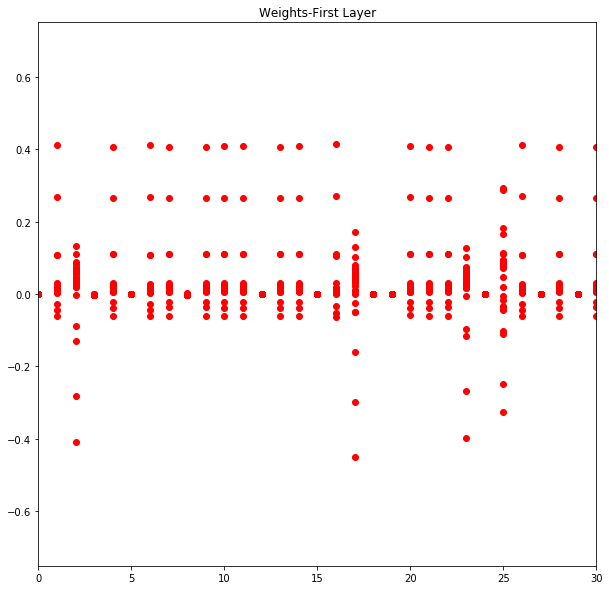

In [4]:
fig   = plt.figure(figsize=(10,10))

ax_fig_1_1 = fig.add_subplot(111)

ax_fig_1_1.clear()

ax_fig_1_1.axis([0, 30, -0.75, 0.75])
ax_fig_1_1.plot(np_arr.transpose(),'ro')
ax_fig_1_1.title.set_text('Weights-First Layer')
# ax_fig_1_1.invert_yaxis()

# from mpl_toolkits.mplot3d import Axes3D
# fig1 = plt.figure()
# ax = fig1.add_subplot(111, projection='3d')
# ax.scatter3D( np.array(29,1),np.array(300,1), 1, cmap='hsv');

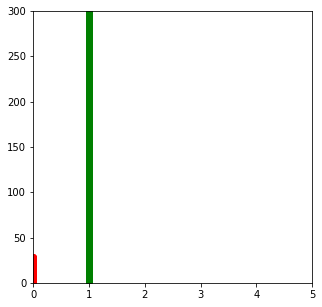

In [5]:
# x = range(1, 300, math.ceil(300/29.7) )
   
fig2   = plt.figure(figsize=(5,5))
ax_fig = fig2.add_subplot(111)
ax_fig.clear()

# Length of X : Number of hidden layers
# Length of Y : Layer size of biggest number of neurons
ax_fig.axis([0, 5, 0, 300])

def create_layer( neuron_numbers, layer_number , offset = 0 ):
    neuron_list_x = []
    neuron_list_y = []
    for x in range(neuron_numbers):
        neuron_list_y.append(x+1)
        neuron_list_x.append(layer_number)

    neuron_list = [ neuron_list_x,neuron_list_y ]

    neuron_list = np.asarray(neuron_list)
    
    return neuron_list

first_layer = create_layer(29,0)
second_layer = create_layer(300,1)


ax_fig.plot(first_layer[0],first_layer[1],'ro')
ax_fig.plot(second_layer[0],second_layer[1],'go')

# ax_fig.title.set_text('Weights-First Layer')

# ax_fig_1_1.invert_yaxis()

plt.show()

In [6]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes)) # vertical
    h_spacing = (right - left)/float(len(layer_sizes) - 1) # horizontal
    
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    
#     print(layer_sizes[:-1])
#     print(layer_sizes[1:])
#     liste = list(zip(layer_sizes[:-1], layer_sizes[1:]))
#     print(liste)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

[2, 15, 5]
[15, 5, 3]
[(2, 15), (15, 5), (5, 3)]


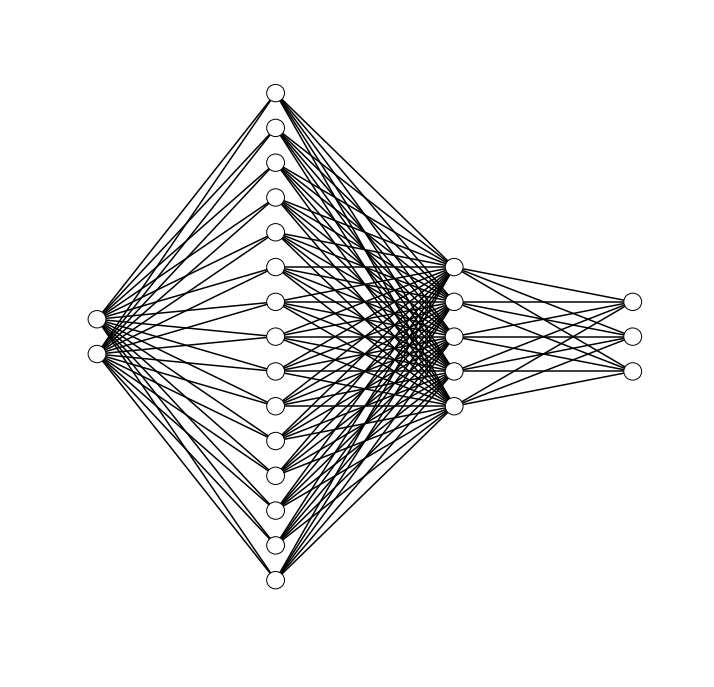

In [71]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [2, 15,5,3])
# fig.savefig('nn.png')

In [7]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
        - coefs_ :(list) length (n_layers - 1) The ith element in the list represents the weight matrix corresponding to layer i.
        - intercepts_ : (list) length (n_layers - 1)The ith element in the list represents the bias vector corresponding to layer i + 1.
        - n_iter_ : (int) The number of iterations the solver has ran.
        - loss_ : (float) The current loss computed with the loss function.
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Input-Arrows
    layer_top_0 = v_spacing*(layer_sizes[0] - 1)/2. + (top + bottom)/2.
    for m in xrange(layer_sizes[0]):
        plt.arrow(left-0.18, layer_top_0 - m*v_spacing, 0.12, 0,  lw =1, head_width=0.01, head_length=0.02)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in xrange(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/8.,\
                            color='w', ec='k', zorder=4)
    # Add texts
        if n == 0:
            plt.text(left-0.125, layer_top - m*v_spacing, r'$X_{'+str(m+1)+'}$', fontsize=15)
        elif (n_layers == 3) & (n == 1):
            plt.text(n*h_spacing + left+0.00, layer_top - m*v_spacing+ (v_spacing/8.+0.01*v_spacing), r'$H_{'+str(m+1)+'}$', fontsize=15)
        elif n == n_layers -1:
            plt.text(n*h_spacing + left+0.10, layer_top - m*v_spacing, r'$y_{'+str(m+1)+'}$', fontsize=15)
        ax.add_artist(circle)# 
    
    # Bias-Nodes
    for n, layer_size in enumerate(layer_sizes):
        if n < n_layers -1:
            x_bias = (n+0.5)*h_spacing + left
            y_bias = top + 0.005
            circle = plt.Circle((x_bias, y_bias), v_spacing/8.,\
                                color='w', ec='k', zorder=4)
    # Add texts
            plt.text(x_bias-(v_spacing/8.+0.10*v_spacing+0.01), y_bias, r'$1$', fontsize=15)
            ax.add_artist(circle)   
    # Edges between nodes
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in xrange(layer_size_a):
            print(m)
            for o in xrange(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
                xm = (n*h_spacing + left)
                xo = ((n + 1)*h_spacing + left)
                ym = (layer_top_a - m*v_spacing)
                yo = (layer_top_b - o*v_spacing)
                rot_mo_rad = np.arctan((yo-ym)/(xo-xm))
                rot_mo_deg = rot_mo_rad*180./np.pi
                xm1 = xm + (v_spacing/8.+0.05)*np.cos(rot_mo_rad)
                if n == 0:
                    if yo > ym:
                        ym1 = ym + (v_spacing/8.+0.12)*np.sin(rot_mo_rad)
                    else:
                        ym1 = ym + (v_spacing/8.+0.05)*np.sin(rot_mo_rad)
                else:
                    if yo > ym:
                        ym1 = ym + (v_spacing/8.+0.12)*np.sin(rot_mo_rad)
                    else:
                        ym1 = ym + (v_spacing/8.+0.04)*np.sin(rot_mo_rad)
                plt.text( xm1, ym1,\
                         str(round(coefs_[n][m, o],4)),\
                         rotation = rot_mo_deg, \
                         fontsize = 10)
                         
    # Edges between bias and nodes
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        if n < n_layers-1:
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
            x_bias = (n+0.5)*h_spacing + left
            y_bias = top + 0.005 
        for o in xrange(layer_size_b):
            print(o)
            line = plt.Line2D([x_bias, (n + 1)*h_spacing + left],
                          [y_bias, layer_top_b - o*v_spacing], c='k')
            ax.add_artist(line)
            xo = ((n + 1)*h_spacing + left)
            yo = (layer_top_b - o*v_spacing)
            rot_bo_rad = np.arctan((yo-y_bias)/(xo-x_bias))
            rot_bo_deg = rot_bo_rad*180./np.pi
            xo2 = xo - (v_spacing/8.+0.01)*np.cos(rot_bo_rad)
            yo2 = yo - (v_spacing/8.+0.01)*np.sin(rot_bo_rad)
            xo1 = xo2 -0.05 *np.cos(rot_bo_rad)
            yo1 = yo2 -0.05 *np.sin(rot_bo_rad)
            plt.text( xo1, yo1,\
                 str(round(intercepts_[n][o],4)),\
                 rotation = rot_bo_deg, \
                 fontsize = 10)   

    # Output-Arrows
    layer_top_0 = v_spacing*(layer_sizes[-1] - 1)/2. + (top + bottom)/2.
    for m in xrange(layer_sizes[-1]):
        plt.arrow(right+0.015, layer_top_0 - m*v_spacing, 0.16*h_spacing, 0,  lw =1, head_width=0.01, head_length=0.02)
    # Record the n_iter_ and loss
    plt.text(left + (right-left)/3., bottom - 0.005*v_spacing, \
             'Steps:'+str(n_iter_)+'    Loss: ' + str(round(loss_, 6)), fontsize = 15)
    


(0.0, 1.0, 0.0, 1.0)

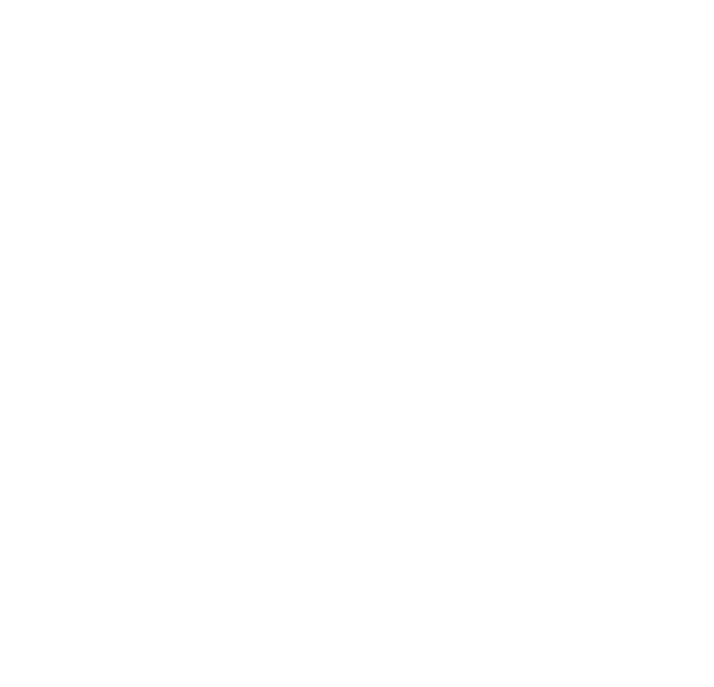

In [8]:
fig66 = plt.figure(figsize=(12, 12))
ax = fig66.gca()
ax.axis('off')

